In [31]:
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Configurações imporantes
IMAGEM_TAMPINHAS = "assets/tampinhas/tampinhas1.jpg"
IMAGEM_MOSAICO = "assets/mosaico/monalisa.jpg"

DIMENSOES_TAMPINHAS = 100
DIMENSOES_MOSAICO = (85, 120) # Mudar de acordo com a resolução e detalhamento da imagem desejada

%matplotlib inline

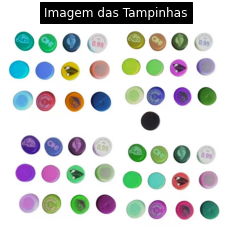

In [33]:
, color='white', backgroundcolor='black'# Carrega a imagem
img_tampinhas = cv.imread(IMAGEM_TAMPINHAS)  # Carrega a imagem especificada
img_tampinhas = cv.cvtColor(img_tampinhas, cv.COLOR_BGR2RGB)  # Converte a imagem de BGR para RGB

# Exibe a imagem das tampinhas
plt.imshow(img_tampinhas)
plt.title('Imagem das Tampinhas', color='white', backgroundcolor='black')
plt.axis('off')
plt.show()

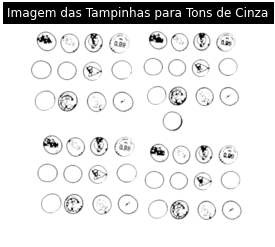

In [34]:
# Converte para tons de cinza
gray = cv.cvtColor(img_tampinhas, cv.COLOR_RGBA2GRAY)

# Aplica desfoque gaussiano e desfoque mediano para suavizar a imagem
gray = cv.GaussianBlur(gray, (5, 5), 0)
gray = cv.medianBlur(gray, 5)

# Aplica limiar adaptativo para binarizar a imagem
gray = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 3.5)

# Aplica erosão e dilatação para remover ruídos e preencher lacunas nos objetos
kernel = np.ones((10, 10), np.uint8)
gray = cv.erode(gray, kernel, iterations=1)
gray = cv.dilate(gray, kernel, iterations=1)

# Aplica mais operações morfológicas para suavizar a imagem e remover detalhes indesejados
kernel = np.ones((5, 5), np.uint8)
gray = cv.GaussianBlur(gray, (15, 15), 0)
gray = cv.morphologyEx(gray, cv.MORPH_OPEN, kernel)
gray = cv.morphologyEx(gray, cv.MORPH_CLOSE, kernel)

# Exibe a imagem resultante
plt.imshow(gray, cmap='gray')
plt.title('Imagem das Tampinhas para Tons de Cinza', color='white', backgroundcolor='black')
plt.axis('off')
plt.show()

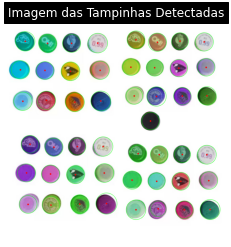

In [35]:
# Detecta círculos na imagem binarizada usando a transformada de Hough
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, dp=1.1, minDist=100, param1=30, param2=50, minRadius=25, maxRadius=150)

# Converte os parâmetros dos círculos detectados para inteiros
circles = np.uint16(np.around(circles))

# Desenha os círculos detectados na imagem original
img_HoughCircles = img_tampinhas.copy()
for i in circles[0, :]:
    # Desenha o círculo externo
    cv.circle(img_HoughCircles, (i[0], i[1]), i[2], (0, 255, 0), 2)
    # Desenha o centro do círculo
    cv.circle(img_HoughCircles, (i[0], i[1]), 2, (255, 0, 0), 10)

# Exibe a imagem resultante com os círculos detectados
plt.imshow(img_HoughCircles)
plt.title('Imagem das Tampinhas Detectadas', color='white', backgroundcolor='black')
plt.axis('off')
plt.show()

In [36]:
# Inicializa uma lista vazia para armazenar os valores RGB das cores das tampinhas encontradas
lista_cores_tampinhas = []

# Itera sobre os círculos detectados
for i, c in enumerate(circles[0]):
    # Obtém as coordenadas (x, y) e o raio (r) do círculo
    x, y, r = c.astype(np.int32)

    # Extrai a região de interesse (ROI) da imagem original contendo a tampinha
    roi = img_tampinhas[y - r: y + r, x - r: x + r]

    # Gera uma máscara circular para isolar a tampinha na ROI
    width, height = roi.shape[:2]
    mask = np.zeros((width, height, 3), roi.dtype)
    cv.circle(mask, (int(width / 2), int(height / 2)), r, (255, 255, 255), -1)

    # Aplica a máscara na ROI para extrair apenas a região da tampinha
    dst = cv.bitwise_and(roi, mask)

    # Filtra a cor preta e obtém os valores médios de cada canal de cor (R, G, B)
    data = []
    for i in range(3):
        channel = dst[:, :, i]
        indices = np.where(channel != 0)[0]  # Obtém os índices onde o canal não é preto
        color = np.mean(channel[indices])    # Calcula a média dos valores dos pixels do canal
        data.append(int(color))              # Adiciona a média à lista de dados da cor

    # Extrai os valores de vermelho, verde e azul da lista de dados
    red, green, blue = data

    # Adiciona os valores RGB da cor da tampinha à lista de cores das tampinhas
    lista_cores_tampinhas.append(np.array([red, green, blue]))

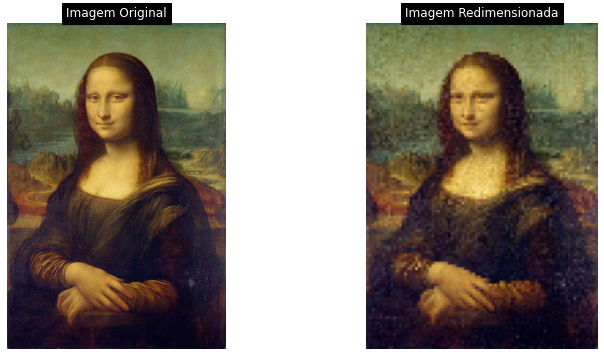

In [37]:
# Carrega a imagem original e converte para RGB
img_mosaico = cv.imread(IMAGEM_MOSAICO)
img_mosaico = cv.cvtColor(img_mosaico, cv.COLOR_BGR2RGB)

# Redimensiona a imagem
img_redimensionada = cv.resize(img_mosaico, dsize=DIMENSOES_MOSAICO)

# Cria a figura e os subplots para exibir as imagens
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Exibe a imagem original no primeiro subplot
axes[0].imshow(img_mosaico)
axes[0].set_title('Imagem Original', color='white', backgroundcolor='black')
axes[0].axis('off')

# Exibe a imagem redimensionada no segundo subplot
axes[1].imshow(img_redimensionada)
axes[1].set_title('Imagem Redimensionada', color='white', backgroundcolor='black')
axes[1].axis('off')

# Exibe os subplots
plt.show()

In [38]:
# Definição da função para calcular a distância entre dois pixels RGB
def distancia_pixel(rgb_alvo, rgb_tampinha):
    # Calcula a distância euclidiana entre os dois pixels RGB
    return np.linalg.norm(rgb_alvo - rgb_tampinha)

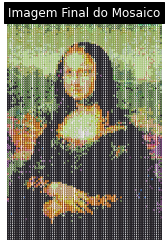

In [39]:
# Cria uma matriz para armazenar a imagem final do mosaico com as dimensões adequadas
img_mosaico_final = np.zeros(shape=(img_redimensionada.shape[0]*DIMENSOES_TAMPINHAS, img_redimensionada.shape[1]*DIMENSOES_TAMPINHAS, 3))

# Percorre cada pixel da imagem redimensionada
for linha in range(img_redimensionada.shape[0]):
    for coluna in range(img_redimensionada.shape[1]):
        # Obtém o valor RGB do pixel atual na imagem redimensionada
        rgb_alvo = img_redimensionada[linha, coluna]

        # Calcula as distâncias entre o pixel atual e as cores das tampinhas na lista
        distancias = [distancia_pixel(rgb_alvo, rgb_tampinha) for rgb_tampinha in lista_cores_tampinhas]
        # Obtém o índice da cor da tampinha mais próxima do pixel atual
        indice = np.argmin(distancias)

        # Obtém as coordenadas e o raio da tampinha correspondente à cor mais próxima
        x, y, r = circles[0][indice].astype(np.int32)
        # Extrai a região da tampinha correspondente
        roi = img_tampinhas[y - r: y + r, x - r: x + r]

        # Gera uma máscara circular para isolar a tampinha
        width, height = roi.shape[:2]
        mask = np.zeros((width, height, 3), roi.dtype)
        cv.circle(mask, (int(width / 2), int(height / 2)), r, (255, 255, 255), -1)

        # Converte a tampinha para o formato RGBA para preservar a transparência
        tampinha_selecionada = cv.cvtColor(roi, cv.COLOR_RGB2RGBA)
        tampinha_selecionada[:, :, 3] = mask[:,:,0]
        tampinha_selecionada = cv.cvtColor(tampinha_selecionada, cv.COLOR_RGBA2RGB)

        # Redimensiona a tampinha para o tamanho desejado
        tampinha_selecionada = cv.resize(tampinha_selecionada, dsize=(DIMENSOES_TAMPINHAS, DIMENSOES_TAMPINHAS))

        # Insere a tampinha na matriz final na posição correspondente ao pixel atual
        img_mosaico_final[linha*DIMENSOES_TAMPINHAS:(linha+1)*DIMENSOES_TAMPINHAS, coluna*DIMENSOES_TAMPINHAS:(coluna+1)*DIMENSOES_TAMPINHAS, :] = tampinha_selecionada

# Exibe a imagem final do mosaico
plt.imshow(img_mosaico_final.astype("uint8"))
plt.title('Imagem Final do Mosaico', color='white', backgroundcolor='black')
plt.axis('off')
plt.show()

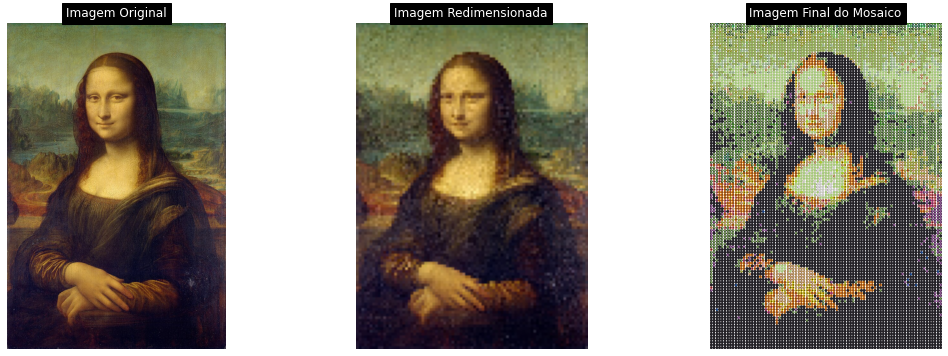

In [40]:
# Exibe as três imagens (original, redimensionada e final) em uma única figura
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Exibe a imagem original no primeiro subplot
axes[0].imshow(img_mosaico)
axes[0].set_title('Imagem Original', color='white', backgroundcolor='black')
axes[0].axis('off')

# Exibe a imagem redimensionada no segundo subplot
axes[1].imshow(img_redimensionada)
axes[1].set_title('Imagem Redimensionada', color='white', backgroundcolor='black')
axes[1].axis('off')

# Exibe a imagem final do mosaico no terceiro subplot
axes[2].imshow(img_mosaico_final.astype("uint8"))
axes[2].set_title('Imagem Final do Mosaico', color='white', backgroundcolor='black')
axes[2].axis('off')

# Exibe os subplots
plt.show()

# Testando Dimensões Diferentes

In [41]:
def redimensionar_imagem(imagem_mosaico, dimensoes_mosaico):
  # Redimensiona a imagem
  img_redimensionada = cv.resize(img_mosaico, dsize=dimensoes_mosaico)

  return img_redimensionada

def mosaico_tampinhas(img_redimensionada):
  # Cria uma matriz para armazenar a imagem final do mosaico com as dimensões adequadas
  img_mosaico_final = np.zeros(shape=(img_redimensionada.shape[0]*DIMENSOES_TAMPINHAS, img_redimensionada.shape[1]*DIMENSOES_TAMPINHAS, 3))

  # Percorre cada pixel da imagem redimensionada
  for linha in range(img_redimensionada.shape[0]):
      for coluna in range(img_redimensionada.shape[1]):
          # Obtém o valor RGB do pixel atual na imagem redimensionada
          rgb_alvo = img_redimensionada[linha, coluna]

          # Calcula as distâncias entre o pixel atual e as cores das tampinhas na lista
          distancias = [distancia_pixel(rgb_alvo, rgb_tampinha) for rgb_tampinha in lista_cores_tampinhas]
          # Obtém o índice da cor da tampinha mais próxima do pixel atual
          indice = np.argmin(distancias)

          # Obtém as coordenadas e o raio da tampinha correspondente à cor mais próxima
          x, y, r = circles[0][indice].astype(np.int32)
          # Extrai a região da tampinha correspondente
          roi = img_tampinhas[y - r: y + r, x - r: x + r]

          # Gera uma máscara circular para isolar a tampinha
          width, height = roi.shape[:2]
          mask = np.zeros((width, height, 3), roi.dtype)
          cv.circle(mask, (int(width / 2), int(height / 2)), r, (255, 255, 255), -1)

          # Converte a tampinha para o formato RGBA para preservar a transparência
          tampinha_selecionada = cv.cvtColor(roi, cv.COLOR_RGB2RGBA)
          tampinha_selecionada[:, :, 3] = mask[:,:,0]
          tampinha_selecionada = cv.cvtColor(tampinha_selecionada, cv.COLOR_RGBA2RGB)

          # Redimensiona a tampinha para o tamanho desejado
          tampinha_selecionada = cv.resize(tampinha_selecionada, dsize=(DIMENSOES_TAMPINHAS, DIMENSOES_TAMPINHAS))

          # Insere a tampinha na matriz final na posição correspondente ao pixel atual
          img_mosaico_final[linha*DIMENSOES_TAMPINHAS:(linha+1)*DIMENSOES_TAMPINHAS, coluna*DIMENSOES_TAMPINHAS:(coluna+1)*DIMENSOES_TAMPINHAS, :] = tampinha_selecionada

  return img_mosaico_final

In [42]:
# Carrega a imagem original e converte para RGB
img_mosaico = cv.imread(IMAGEM_MOSAICO)
img_mosaico = cv.cvtColor(img_mosaico, cv.COLOR_BGR2RGB)

dimensoes_mosaico_1 = DIMENSOES_MOSAICO
img_redimensionada_1 = redimensionar_imagem(img_mosaico, dimensoes_mosaico_1)
img_mosaico_final_1 = mosaico_tampinhas(img_redimensionada_1)

dimensoes_mosaico_2 = (55, 80)
img_redimensionada_2 = redimensionar_imagem(img_mosaico, dimensoes_mosaico_2)
img_mosaico_final_2 = mosaico_tampinhas(img_redimensionada_2)

dimensoes_mosaico_3 = (17, 25)
img_redimensionada_3 = redimensionar_imagem(img_mosaico, dimensoes_mosaico_3)
img_mosaico_final_3 = mosaico_tampinhas(img_redimensionada_3)

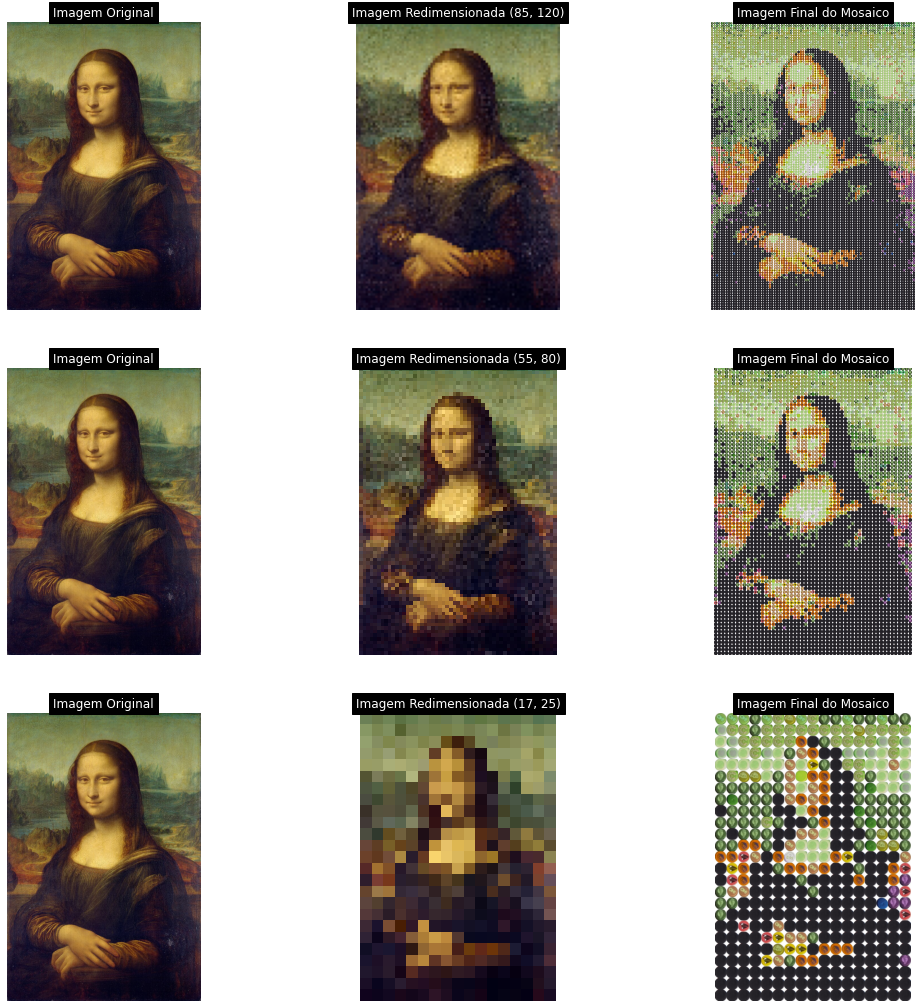

In [43]:
# Exibe as três imagens (original, redimensionada e final) em uma única figura
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Exibe a imagem original no primeiro subplot
axes[0][0].imshow(img_mosaico)
axes[0][0].set_title('Imagem Original', color='white', backgroundcolor='black')
axes[0][0].axis('off')

# Exibe a imagem redimensionada no segundo subplot
axes[0][1].imshow(img_redimensionada_1)
axes[0][1].set_title(f'Imagem Redimensionada {dimensoes_mosaico_1}', color='white', backgroundcolor='black')
axes[0][1].axis('off')

# Exibe a imagem final do mosaico no terceiro subplot
axes[0][2].imshow(img_mosaico_final_1.astype("uint8"))
axes[0][2].set_title('Imagem Final do Mosaico', color='white', backgroundcolor='black')
axes[0][2].axis('off')

# Exibe a imagem original no primeiro subplot
axes[1][0].imshow(img_mosaico)
axes[1][0].set_title('Imagem Original', color='white', backgroundcolor='black')
axes[1][0].axis('off')

# Exibe a imagem redimensionada no segundo subplot
axes[1][1].imshow(img_redimensionada_2)
axes[1][1].set_title(f'Imagem Redimensionada {dimensoes_mosaico_2}', color='white', backgroundcolor='black')
axes[1][1].axis('off')

# Exibe a imagem final do mosaico no terceiro subplot
axes[1][2].imshow(img_mosaico_final_2.astype("uint8"))
axes[1][2].set_title('Imagem Final do Mosaico', color='white', backgroundcolor='black')
axes[1][2].axis('off')

# Exibe a imagem original no primeiro subplot
axes[2][0].imshow(img_mosaico)
axes[2][0].set_title('Imagem Original', color='white', backgroundcolor='black')
axes[2][0].axis('off')

# Exibe a imagem redimensionada no segundo subplot
axes[2][1].imshow(img_redimensionada_3)
axes[2][1].set_title(f'Imagem Redimensionada {dimensoes_mosaico_3}', color='white', backgroundcolor='black')
axes[2][1].axis('off')

# Exibe a imagem final do mosaico no terceiro subplot
axes[2][2].imshow(img_mosaico_final_3.astype("uint8"))
axes[2][2].set_title('Imagem Final do Mosaico', color='white', backgroundcolor='black')
axes[2][2].axis('off')

# Exibe os subplots
plt.show()